# Udacity Self-Driving Car Engineer Nanodegree Program

# Vehicle Detection Project

# 0 Helper Functions

In [34]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2, os
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time
%matplotlib inline

In [35]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    '''画方框。'''
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick)
    return draw_img # Change this line to return image copy with boxes

In [36]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    '''颜色的 histogram 特征'''
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [37]:
def bin_spatial(img, size=(32, 32)):
    '''缩减图片的分辨率'''
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel() 
    color3 = cv2.resize(img[:,:,2], size).ravel() 

    # Return the feature vector
    return np.hstack((color1, color2, color3))

In [38]:
def get_hog_features(img, orient = 9, pix_per_cell = 8, cell_per_block = 2, vis=False, feature_vec=True):
    '''获取 HOG 特征'''
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img,orient,(pix_per_cell,pix_per_cell),(cell_per_block,cell_per_block),visualise = vis, feature_vector= feature_vec)
            
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img,orient,(pix_per_cell,pix_per_cell),(cell_per_block,cell_per_block), visualise = vis)
        return features

In [39]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        # image = mpimg.imread(file)
        image = file
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [40]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

def train_model(data,label,parameters = param_grid):
    '''训练模型'''
    svr = svm.SVC()
    clf = GridSearchCV(svr, parameters)
    clf.fit(data,label)
    model = clf
    return model

In [41]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    '''移动搜索的窗口'''
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [42]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
            else:
                
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        
        return np.concatenate(img_features)

In [43]:
# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [44]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    ystart = 400
    ystop = 656
    scale = 1.5
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)

    return draw_img

In [45]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [46]:
#Define function for plotting multiple images.
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

## 0.1 Folders Init

In [47]:
starter_code = R'D:\\Github\\CarND-Vehicle-Detection-and-Tracking\\Starter-Code'
dataset = R'D:\\Github\\CarND-Vehicle-Detection-and-Tracking\\dataset'

## 0.2 Load Dataset and Visualize Images

In [48]:
os.chdir(dataset)
with open('data_to_save.pickle','rb') as f:
    data_to_save = pickle.load(f)

In [49]:
car_imgs = data_to_save['car_imgs']
non_car_imgs = data_to_save['non_car_imgs']
print('Number of car images:', car_imgs.shape[0])
print('Number of non car images:', non_car_imgs.shape[0])

Number of car images: 8792
Number of non car images: 8968


In [50]:
y_car = np.ones((car_imgs.shape[0],1))
y_non_car = np.ones((non_car_imgs.shape[0],1))

dataset has 17760 images in total.


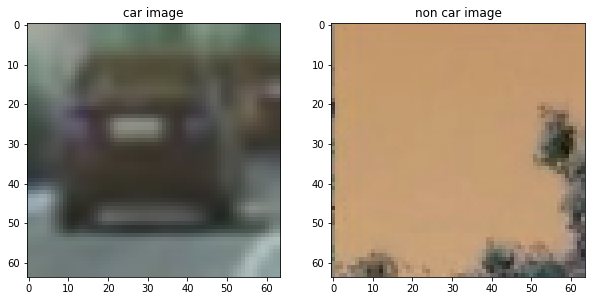

In [51]:
X = np.concatenate((car_imgs,non_car_imgs))
y = np.concatenate((y_car,y_non_car))
assert X.shape[0] == y.shape[0]
print('dataset has {} images in total.'.format(X.shape[0]))

fi,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(car_imgs[0])
ax1.set_title('car image')
ax2.imshow(non_car_imgs[0])
ax2.set_title('non car image')

### 0.2.1 Test on feature extraction

D:\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


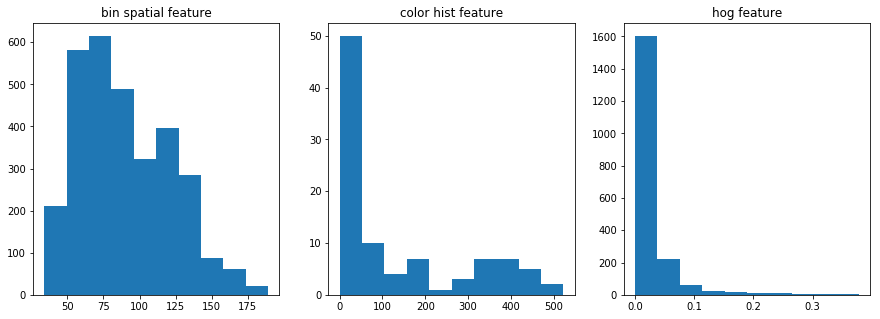

In [71]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.hist(bin_spatial(car_imgs[0]))
ax1.set_title('bin spatial feature')
ax2.hist(color_hist(car_imgs[0]))
ax2.set_title('color hist feature')
ax3.hist(get_hog_features(car_imgs[0][:,:,0],orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
ax3.set_title('hog feature')

### 0.2.2 Features' info

In [78]:
bin0 = bin_spatial(car_imgs[0])
color0 = color_hist(car_imgs[0])
hog0 = get_hog_features(car_imgs[0][:,:,0],orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
print('bin spatial length is:',bin0.shape[0],', and type is:',type(bin0))
print('color hist feature length is:',color0.shape[0],', and type is:',type(color0))
print('hog feature length is:',hog0.shape[0],', and type is:',type(hog0))
print('If hog uses all 3 channels, then the whole feature length is:',bin0.shape[0]+color0.shape[0]+3*hog0.shape[0])
print('If hog uses 1 channel, then the whole feature length is:',bin0.shape[0]+color0.shape[0]+hog0.shape[0])

bin spatial length is: 3072 , and type is: <class 'numpy.ndarray'>
color hist feature length is: 96 , and type is: <class 'numpy.ndarray'>
hog feature length is: 1960 , and type is: <class 'numpy.ndarray'>
If hog uses all 3 channels, then the whole feature length is: 9048
If hog uses 1 channel, then the whole feature length is: 5128


D:\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## 0.3 Extract Features and Normalize

D:\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


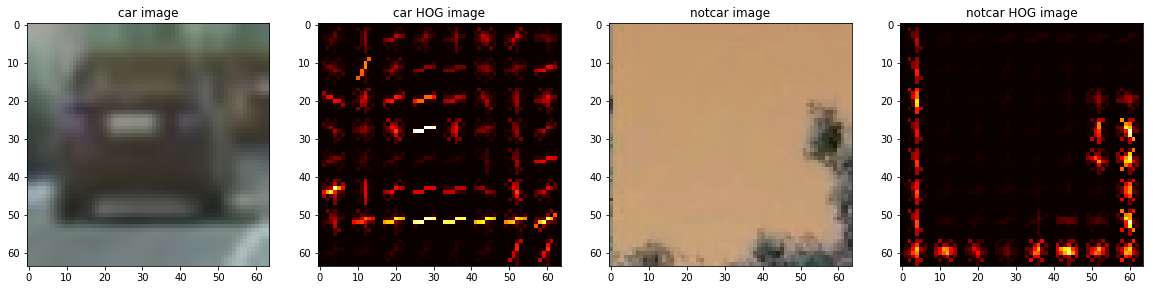

In [52]:
%matplotlib inline 

#Define Feature parameter
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features, car_hog_image = single_img_features(car_imgs[0], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(non_car_imgs[0], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)


images = [car_imgs[0], car_hog_image, non_car_imgs[0], notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(20, 5))
visualize(fig, 1, 4, images, titles)

# 1 Histogram of Oriented Gradients (HOG)

## 1.1 Explain how you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

In [53]:
#Define Feature parameter
t=time.time()
#n_samples = 100
#random_idxs = np.random.randint(0, len(cars), n_samples)
# random_idxs = np.random.randint(0,car_imgs.shape[0], 10)
random_idxs = range(5)
test_cars = car_imgs[random_idxs] #np.array(cars)[random_idxs]
test_notcars = non_car_imgs[random_idxs] #np.array(notcars)[random_idxs]

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features....')


X = np.vstack((car_features[0],notcar_features[0])).astype(np.float64)                       
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block',
     hist_bins, 'histograms bins, and', spatial_size, 'spatial sampling.' )
print('Feature vector length:', len(X_train[0]))

0.02300119400024414 Seconds to compute features....


D:\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


ValueError: Found input variables with inconsistent numbers of samples: [2, 10]

In [29]:
len(notcar_features[0].tolist())

5037

In [30]:
len(car_features[0].tolist())

5037

In [31]:
a = car_features[0].tolist()
b = notcar_features[0].tolist()

In [32]:
mask=[1 if type(i)!=int else 0 for i in a]
mask.index(1,3073,5000)

3073

In [ ]:
a[3072]

In [ ]:
a[3073]

In [ ]:
a[3074]

In [33]:
car_features

[array([164, 122, 127, ..., 0.003630700272306292, 0.004628252921440684,
        0.0026463048103861574], dtype=object),
 array([164, 122, 127, ..., 0.008012724605137009, 0.01746324068330134,
        0.06192959371322502], dtype=object),
 array([148, 124, 123, ..., 0.0047331693012395626, 0.008746344804573465,
        0.003944307928355794], dtype=object),
 array([95, 122, 129, ..., 0.007566649467387369, 0.03538286666532131,
        0.10027446260740061], dtype=object),
 array([103, 120, 128, ..., 0.01045261203146683, 0.021759501012437767,
        0.05142304785176321], dtype=object)]

## 1.2 Describe how you trained a classifier using your selected HOG features (and color features if you used them).

# 2 Sliding Window Search

## 2.1 Describe how you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

## 2.2 Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

# 3 Video Implementation

## 3.1 Provide a link to your final video output. 

Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

## 3.2 Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.